In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

import torch
print(torch.cuda.device_count())   # should be 1 now
print(torch.cuda.get_device_name(0))  # GPU 8 will appear as cuda:0

import torch

print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Number of visible GPUs: {torch.cuda.device_count()}")

for i in range(torch.cuda.device_count()):
    print(f"Device {i}: {torch.cuda.get_device_name(i)}")



1
NVIDIA L40S
CUDA available: True
Number of visible GPUs: 1
Device 0: NVIDIA L40S


In [2]:
import cv2
import numpy as np
import torch
import pandas as pd
from tqdm import tqdm
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
import os

def preprocess_image(image_path, target_size=(1024, 1024)):
    """Pad image to square and resize"""
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Cannot load: {image_path}")
    
    h, w = image.shape[:2]
    max_dim = max(h, w)
    
    # Pad to square
    pad_h, pad_w = max_dim - h, max_dim - w
    top, left = pad_h // 2, pad_w // 2
    bottom, right = pad_h - top, pad_w - left
    
    padded = cv2.copyMakeBorder(image, top, bottom, left, right, 
                               cv2.BORDER_CONSTANT, value=[0, 0, 0])
    
    # Resize
    resized = cv2.resize(padded, target_size, interpolation=cv2.INTER_LANCZOS4)
    return resized

def load_models():
    """Load both models"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using: {device}")
    
    # RadDiNo
    raddino_processor = AutoImageProcessor.from_pretrained("microsoft/rad-dino")
    raddino_model = AutoModel.from_pretrained("microsoft/rad-dino").to(device).eval()
    
    # DINOv3
    dinov3_processor = AutoImageProcessor.from_pretrained("facebook/dinov3-vit7b16-pretrain-lvd1689m")
    dinov3_model = AutoModel.from_pretrained("facebook/dinov3-vit7b16-pretrain-lvd1689m").to(device).eval()
    
    return (raddino_processor, raddino_model, dinov3_processor, dinov3_model, device)

def extract_embeddings(images, processors_models):
    """Extract embeddings for batch of images"""
    raddino_proc, raddino_model, dinov3_proc, dinov3_model, device = processors_models
    
    # Convert to PIL
    pil_images = []
    for img in images:
        if img.ndim == 3:
            pil_img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        else:
            pil_img = Image.fromarray(img).convert("RGB")
        pil_images.append(pil_img)
    
    with torch.no_grad():
        # RadDiNo
        inputs = raddino_proc(pil_images, return_tensors="pt").to(device)
        outputs = raddino_model(**inputs)
        raddino_embs = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        
        # DINOv3  
        inputs = dinov3_proc(pil_images, return_tensors="pt").to(device)
        outputs = dinov3_model(**inputs)
        dinov3_embs = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    return raddino_embs, dinov3_embs

def process_csv(csv_path, root_path, output_path, batch_size=16):
    """Main function - process any CSV with ImagePath column"""
    
    # Load data
    df = pd.read_csv(csv_path)
    print(f"Processing {len(df)} images")
    print(f"Columns: {list(df.columns)}")
    
    # Load models once
    models = load_models()
    
    # Initialize embedding columns
    df['raddino_embedding'] = None
    df['dinov3_embedding'] = None
    
    # Process in batches
    for i in tqdm(range(0, len(df), batch_size), desc="Processing"):
        batch_df = df.iloc[i:i+batch_size]
        batch_images = []
        valid_indices = []
        
        # Load images
        for idx, row in batch_df.iterrows():
            try:
                img_path = os.path.join(root_path, row['ImagePath'])
                img = preprocess_image(img_path)
                batch_images.append(img)
                valid_indices.append(idx)
            except:
                continue
        
        if len(batch_images) == 0:
            continue
            
        # Extract embeddings
        raddino_embs, dinov3_embs = extract_embeddings(batch_images, models)
        
        # Store results
        for j, idx in enumerate(valid_indices):
            df.at[idx, 'raddino_embedding'] = raddino_embs[j].tolist()
            df.at[idx, 'dinov3_embedding'] = dinov3_embs[j].tolist()
    
    # Save
    df.to_parquet(output_path, index=False)
    
    # Summary
    success = df['raddino_embedding'].notna().sum()
    print(f"Success: {success}/{len(df)} images")
    print(f"Saved: {output_path}")
    
    return df


/mnt/NAS3/homes/rmuthy2/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:

# Usage
if __name__ == "__main__":
    # Just change these 3 lines for any dataset
    CSV_PATH = "/home/rmuthy2/Disease_Classification/diseases.csv"        # Your CSV
    ROOT_PATH =  "/home/rmuthy2/central_data/datasets/internal/EmoryCXRv2/ORIGINAL_PNG"           # Image root folder  
    OUTPUT_PATH = "/home/rmuthy2/Disease_Classification/llembeddings.parquet"      # Output file
    
    # Run
    df = process_csv(CSV_PATH, ROOT_PATH, OUTPUT_PATH, batch_size=16)

Processing 137286 images
Columns: ['AccessionNumber_anon', 'ImagePath', 'ViewPosition', 'CLAHE', 'Cardiomegaly', 'Lung Lesion', 'Edema']
Using: cuda


Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 10645.44it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Processing: 100%|██████████| 8581/8581 [10:44:13<00:00,  4.50s/it] 


Success: 137286/137286 images
Saved: /home/rmuthy2/Disease_Classification/llembeddings.parquet


In [5]:
# linear_probe.py
import ast
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
import matplotlib.pyplot as plt


In [8]:
df = pd.read_parquet("/home/rmuthy2/Disease_Classification/llembeddings.parquet")
df.head()

,AccessionNumber_anon,ImagePath,ViewPosition,CLAHE,Cardiomegaly,Lung Lesion,Edema,raddino_embedding,dinov3_embedding
0,2149448880903238,60577834/2149448880903238/1.2.826.0.1.3680043....,AP,0.0,0.0,0.0,0.0,"[-0.009326547384262085, 0.20279009640216827, 0...","[0.07344235479831696, 0.028413552790880203, 0...."
1,3389141075833202,59540318/3389141075833202/1.2.826.0.1.3680043....,AP,0.0,1.0,0.0,0.0,"[0.036672670394182205, 0.21812649071216583, 0....","[0.0506211593747139, 0.027290424332022667, 0.1..."
2,7339638960955001,69812440/7339638960955001/1.2.826.0.1.3680043....,AP,0.0,0.0,0.0,0.0,"[0.029661286622285843, 0.20676152408123016, 0....","[0.0246542077511549, 0.03358527645468712, 0.09..."
3,348232069684,33792794/348232069684/1.2.826.0.1.3680043.8.49...,AP,0.0,1.0,0.0,0.0,"[0.039942339062690735, 0.07460657507181168, 0....","[0.04999804496765137, 0.0650201365351677, 0.10..."
4,193856787426,52272490/193856787426/1.2.826.0.1.3680043.8.49...,AP,0.0,1.0,0.0,0.0,"[0.004925863351672888, 0.24669651687145233, 0....","[0.059935715049505234, 0.013121908530592918, 0..."


In [9]:
df.shape

(137286, 9)

Loading /home/rmuthy2/Disease_Classification/llembeddings.parquet … using embeddings: raddino_embedding

AUC (test): 0.7819

Classification Report (test):
              precision    recall  f1-score   support

           0     0.7100    0.6735    0.6913       487
           1     0.6895    0.7248    0.7067       487

    accuracy                         0.6992       974
   macro avg     0.6997    0.6992    0.6990       974
weighted avg     0.6997    0.6992    0.6990       974


Saved ROC curve to: /mnt/NAS3/homes/rmuthy2/Disease_Classification/roc_raddino_embedding.png


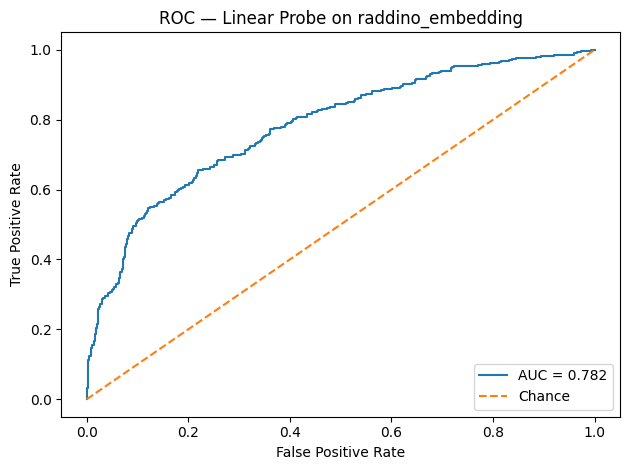

In [6]:

# ----------------------------
# config
PARQUET_PATH = "/home/rmuthy2/Disease_Classification/llembeddings.parquet"  # <-- set this
EMBED_COL = "raddino_embedding"     # or "dinov3_embedding"
TARGET_COL = "Lung Lesion"          # note the space
TEST_SIZE = 0.2
RANDOM_STATE = 42
# ----------------------------

def parse_embedding(x):
    """
    Handles list/np.array or stringified list (e.g., '[0.1, 0.2, ...]').
    Returns a 1D numpy array.
    """
    if isinstance(x, (list, np.ndarray)):
        return np.asarray(x, dtype=float)
    if isinstance(x, str):
        try:
            return np.asarray(ast.literal_eval(x), dtype=float)
        except Exception:
            # Try comma-separated fallback
            parts = [p for p in x.strip("[]() ").split(",") if p]
            return np.asarray([float(p) for p in parts], dtype=float)
    raise ValueError(f"Unsupported embedding type: {type(x)}")

def load_balanced_embeddings(parquet_path, embed_col, target_col):
    df = pd.read_parquet(parquet_path)

    # Keep rows that have target and embedding
    df = df[[embed_col, target_col]].dropna()

    # Parse embeddings to arrays
    embs = df[embed_col].apply(parse_embedding)

    # Sanity: ensure fixed dim
    dim = len(embs.iloc[0])
    if not embs.apply(lambda a: len(a) == dim).all():
        raise ValueError("Embeddings have inconsistent dimensions.")

    X_all = np.vstack(embs.values)
    y_all = df[target_col].astype(int).values

    # Balance classes by undersampling the majority BEFORE split
    idx0 = np.where(y_all == 0)[0]
    idx1 = np.where(y_all == 1)[0]
    n = min(len(idx0), len(idx1))
    rng = np.random.default_rng(RANDOM_STATE)
    idx0_s = rng.choice(idx0, size=n, replace=False)
    idx1_s = rng.choice(idx1, size=n, replace=False)
    sel = np.concatenate([idx0_s, idx1_s])
    rng.shuffle(sel)

    return X_all[sel], y_all[sel]

def main():
    print(f"Loading {PARQUET_PATH} … using embeddings: {EMBED_COL}")
    X, y = load_balanced_embeddings(PARQUET_PATH, EMBED_COL, TARGET_COL)

    # Stratified split (keeps 50/50 balance in both train & test)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
    )

    # Scale features for linear probe
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s  = scaler.transform(X_test)

    # Simple, strong baseline: L2-logreg
    clf = LogisticRegression(
        penalty="l2",
        solver="liblinear",  # robust for small/medium feature dims
        random_state=RANDOM_STATE,
        max_iter=2000,
        n_jobs=None
    )
    clf.fit(X_train_s, y_train)

    # Evaluate
    prob_test = clf.predict_proba(X_test_s)[:, 1]
    auc = roc_auc_score(y_test, prob_test)
    print(f"\nAUC (test): {auc:.4f}")

    # Threshold at 0.5 for report (you can tune this)
    y_pred = (prob_test >= 0.5).astype(int)
    print("\nClassification Report (test):")
    print(classification_report(y_test, y_pred, digits=4))

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, prob_test)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--", label="Chance")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC — Linear Probe on {EMBED_COL}")
    plt.legend(loc="lower right")
    plt.tight_layout()
    out_png = Path(f"roc_{EMBED_COL}.png")
    plt.savefig(out_png, dpi=200)
    print(f"\nSaved ROC curve to: {out_png.resolve()}")

if __name__ == "__main__":
    main()


Loading /home/rmuthy2/Disease_Classification/llembeddings.parquet … using embeddings: dinov3_embedding

AUC (test): 0.6804

Classification Report (test):
              precision    recall  f1-score   support

           0     0.6304    0.6550    0.6425       487
           1     0.6410    0.6160    0.6283       487

    accuracy                         0.6355       974
   macro avg     0.6357    0.6355    0.6354       974
weighted avg     0.6357    0.6355    0.6354       974


Saved ROC curve to: /mnt/NAS3/homes/rmuthy2/Disease_Classification/roc_dinov3_embedding.png


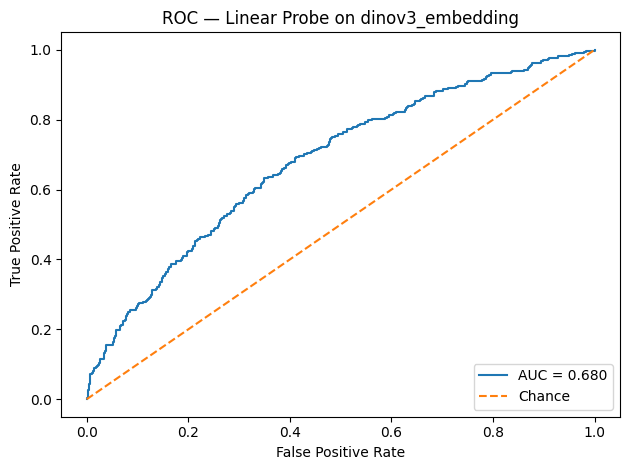

In [7]:

# ----------------------------
# config
PARQUET_PATH = "/home/rmuthy2/Disease_Classification/llembeddings.parquet"  # <-- set this
EMBED_COL = "dinov3_embedding"     # or "dinov3_embedding"
TARGET_COL = "Lung Lesion"          # note the space
TEST_SIZE = 0.2
RANDOM_STATE = 42
# ----------------------------

def parse_embedding(x):
    """
    Handles list/np.array or stringified list (e.g., '[0.1, 0.2, ...]').
    Returns a 1D numpy array.
    """
    if isinstance(x, (list, np.ndarray)):
        return np.asarray(x, dtype=float)
    if isinstance(x, str):
        try:
            return np.asarray(ast.literal_eval(x), dtype=float)
        except Exception:
            # Try comma-separated fallback
            parts = [p for p in x.strip("[]() ").split(",") if p]
            return np.asarray([float(p) for p in parts], dtype=float)
    raise ValueError(f"Unsupported embedding type: {type(x)}")

def load_balanced_embeddings(parquet_path, embed_col, target_col):
    df = pd.read_parquet(parquet_path)

    # Keep rows that have target and embedding
    df = df[[embed_col, target_col]].dropna()

    # Parse embeddings to arrays
    embs = df[embed_col].apply(parse_embedding)

    # Sanity: ensure fixed dim
    dim = len(embs.iloc[0])
    if not embs.apply(lambda a: len(a) == dim).all():
        raise ValueError("Embeddings have inconsistent dimensions.")

    X_all = np.vstack(embs.values)
    y_all = df[target_col].astype(int).values

    # Balance classes by undersampling the majority BEFORE split
    idx0 = np.where(y_all == 0)[0]
    idx1 = np.where(y_all == 1)[0]
    n = min(len(idx0), len(idx1))
    rng = np.random.default_rng(RANDOM_STATE)
    idx0_s = rng.choice(idx0, size=n, replace=False)
    idx1_s = rng.choice(idx1, size=n, replace=False)
    sel = np.concatenate([idx0_s, idx1_s])
    rng.shuffle(sel)

    return X_all[sel], y_all[sel]

def main():
    print(f"Loading {PARQUET_PATH} … using embeddings: {EMBED_COL}")
    X, y = load_balanced_embeddings(PARQUET_PATH, EMBED_COL, TARGET_COL)

    # Stratified split (keeps 50/50 balance in both train & test)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
    )

    # Scale features for linear probe
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s  = scaler.transform(X_test)

    # Simple, strong baseline: L2-logreg
    clf = LogisticRegression(
        penalty="l2",
        solver="liblinear",  # robust for small/medium feature dims
        random_state=RANDOM_STATE,
        max_iter=2000,
        n_jobs=None
    )
    clf.fit(X_train_s, y_train)

    # Evaluate
    prob_test = clf.predict_proba(X_test_s)[:, 1]
    auc = roc_auc_score(y_test, prob_test)
    print(f"\nAUC (test): {auc:.4f}")

    # Threshold at 0.5 for report (you can tune this)
    y_pred = (prob_test >= 0.5).astype(int)
    print("\nClassification Report (test):")
    print(classification_report(y_test, y_pred, digits=4))

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, prob_test)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--", label="Chance")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC — Linear Probe on {EMBED_COL}")
    plt.legend(loc="lower right")
    plt.tight_layout()
    out_png = Path(f"roc_{EMBED_COL}.png")
    plt.savefig(out_png, dpi=200)
    print(f"\nSaved ROC curve to: {out_png.resolve()}")

if __name__ == "__main__":
    main()


Loading /home/rmuthy2/Disease_Classification/llembeddings.parquet … using embeddings: raddino_embedding

AUC (test): 0.8326

Classification Report (test):
              precision    recall  f1-score   support

           0     0.7581    0.7558    0.7570     13729
           1     0.7565    0.7589    0.7577     13729

    accuracy                         0.7573     27458
   macro avg     0.7573    0.7573    0.7573     27458
weighted avg     0.7573    0.7573    0.7573     27458


Saved ROC curve to: /mnt/NAS3/homes/rmuthy2/Disease_Classification/roc_raddino_embedding.png


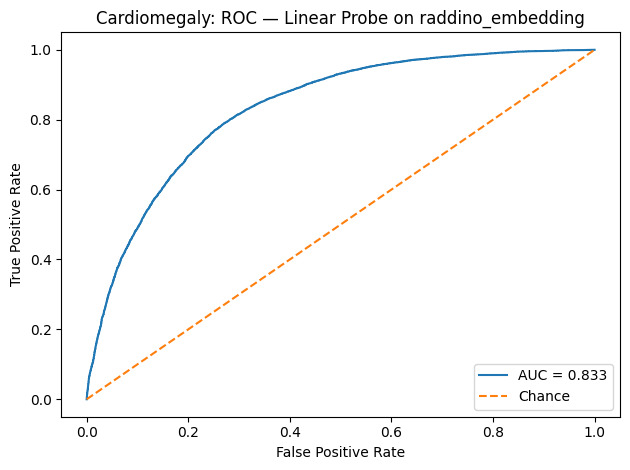

In [11]:

# ----------------------------
# config
PARQUET_PATH = "/home/rmuthy2/Disease_Classification/llembeddings.parquet"  # <-- set this
EMBED_COL = "raddino_embedding"     # or "dinov3_embedding"
TARGET_COL = "Cardiomegaly"          # note the space
TEST_SIZE = 0.2
RANDOM_STATE = 42
# ----------------------------

def parse_embedding(x):
    """
    Handles list/np.array or stringified list (e.g., '[0.1, 0.2, ...]').
    Returns a 1D numpy array.
    """
    if isinstance(x, (list, np.ndarray)):
        return np.asarray(x, dtype=float)
    if isinstance(x, str):
        try:
            return np.asarray(ast.literal_eval(x), dtype=float)
        except Exception:
            # Try comma-separated fallback
            parts = [p for p in x.strip("[]() ").split(",") if p]
            return np.asarray([float(p) for p in parts], dtype=float)
    raise ValueError(f"Unsupported embedding type: {type(x)}")

def load_balanced_embeddings(parquet_path, embed_col, target_col):
    df = pd.read_parquet(parquet_path)

    # Keep rows that have target and embedding
    df = df[[embed_col, target_col]].dropna()

    # Parse embeddings to arrays
    embs = df[embed_col].apply(parse_embedding)

    # Sanity: ensure fixed dim
    dim = len(embs.iloc[0])
    if not embs.apply(lambda a: len(a) == dim).all():
        raise ValueError("Embeddings have inconsistent dimensions.")

    X_all = np.vstack(embs.values)
    y_all = df[target_col].astype(int).values

    # Balance classes by undersampling the majority BEFORE split
    idx0 = np.where(y_all == 0)[0]
    idx1 = np.where(y_all == 1)[0]
    n = min(len(idx0), len(idx1))
    rng = np.random.default_rng(RANDOM_STATE)
    idx0_s = rng.choice(idx0, size=n, replace=False)
    idx1_s = rng.choice(idx1, size=n, replace=False)
    sel = np.concatenate([idx0_s, idx1_s])
    rng.shuffle(sel)

    return X_all[sel], y_all[sel]

def main():
    print(f"Loading {PARQUET_PATH} … using embeddings: {EMBED_COL}")
    X, y = load_balanced_embeddings(PARQUET_PATH, EMBED_COL, TARGET_COL)

    # Stratified split (keeps 50/50 balance in both train & test)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
    )

    # Scale features for linear probe
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s  = scaler.transform(X_test)

    # Simple, strong baseline: L2-logreg
    clf = LogisticRegression(
        penalty="l2",
        solver="liblinear",  # robust for small/medium feature dims
        random_state=RANDOM_STATE,
        max_iter=2000,
        n_jobs=None
    )
    clf.fit(X_train_s, y_train)

    # Evaluate
    prob_test = clf.predict_proba(X_test_s)[:, 1]
    auc = roc_auc_score(y_test, prob_test)
    print(f"\nAUC (test): {auc:.4f}")

    # Threshold at 0.5 for report (you can tune this)
    y_pred = (prob_test >= 0.5).astype(int)
    print("\nClassification Report (test):")
    print(classification_report(y_test, y_pred, digits=4))

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, prob_test)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--", label="Chance")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"Cardiomegaly: ROC — Linear Probe on {EMBED_COL}")
    plt.legend(loc="lower right")
    plt.tight_layout()
    out_png = Path(f"roc_{EMBED_COL}.png")
    plt.savefig(out_png, dpi=200)
    print(f"\nSaved ROC curve to: {out_png.resolve()}")

if __name__ == "__main__":
    main()


Loading /home/rmuthy2/Disease_Classification/llembeddings.parquet … using embeddings: dinov3_embedding

AUC (test): 0.8025

Classification Report (test):
              precision    recall  f1-score   support

           0     0.7276    0.7254    0.7265     13729
           1     0.7262    0.7284    0.7273     13729

    accuracy                         0.7269     27458
   macro avg     0.7269    0.7269    0.7269     27458
weighted avg     0.7269    0.7269    0.7269     27458


Saved ROC curve to: /mnt/NAS3/homes/rmuthy2/Disease_Classification/roc_dinov3_embedding.png


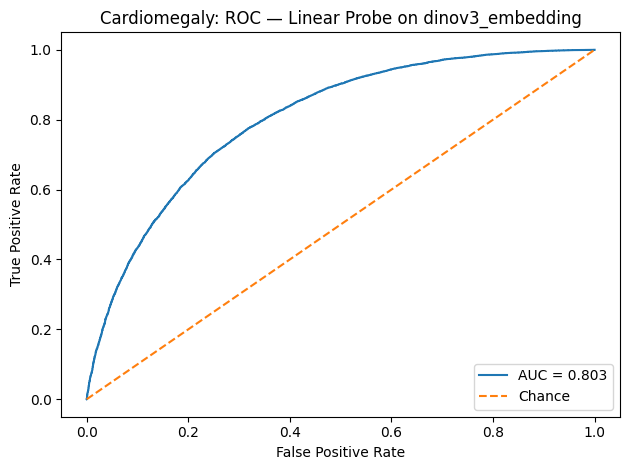

In [12]:

# ----------------------------
# config
PARQUET_PATH = "/home/rmuthy2/Disease_Classification/llembeddings.parquet"  # <-- set this
EMBED_COL = "dinov3_embedding"     # or "dinov3_embedding"
TARGET_COL = "Cardiomegaly"          # note the space
TEST_SIZE = 0.2
RANDOM_STATE = 42
# ----------------------------

def parse_embedding(x):
    """
    Handles list/np.array or stringified list (e.g., '[0.1, 0.2, ...]').
    Returns a 1D numpy array.
    """
    if isinstance(x, (list, np.ndarray)):
        return np.asarray(x, dtype=float)
    if isinstance(x, str):
        try:
            return np.asarray(ast.literal_eval(x), dtype=float)
        except Exception:
            # Try comma-separated fallback
            parts = [p for p in x.strip("[]() ").split(",") if p]
            return np.asarray([float(p) for p in parts], dtype=float)
    raise ValueError(f"Unsupported embedding type: {type(x)}")

def load_balanced_embeddings(parquet_path, embed_col, target_col):
    df = pd.read_parquet(parquet_path)

    # Keep rows that have target and embedding
    df = df[[embed_col, target_col]].dropna()

    # Parse embeddings to arrays
    embs = df[embed_col].apply(parse_embedding)

    # Sanity: ensure fixed dim
    dim = len(embs.iloc[0])
    if not embs.apply(lambda a: len(a) == dim).all():
        raise ValueError("Embeddings have inconsistent dimensions.")

    X_all = np.vstack(embs.values)
    y_all = df[target_col].astype(int).values

    # Balance classes by undersampling the majority BEFORE split
    idx0 = np.where(y_all == 0)[0]
    idx1 = np.where(y_all == 1)[0]
    n = min(len(idx0), len(idx1))
    rng = np.random.default_rng(RANDOM_STATE)
    idx0_s = rng.choice(idx0, size=n, replace=False)
    idx1_s = rng.choice(idx1, size=n, replace=False)
    sel = np.concatenate([idx0_s, idx1_s])
    rng.shuffle(sel)

    return X_all[sel], y_all[sel]

def main():
    print(f"Loading {PARQUET_PATH} … using embeddings: {EMBED_COL}")
    X, y = load_balanced_embeddings(PARQUET_PATH, EMBED_COL, TARGET_COL)

    # Stratified split (keeps 50/50 balance in both train & test)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
    )

    # Scale features for linear probe
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s  = scaler.transform(X_test)

    # Simple, strong baseline: L2-logreg
    clf = LogisticRegression(
        penalty="l2",
        solver="liblinear",  # robust for small/medium feature dims
        random_state=RANDOM_STATE,
        max_iter=2000,
        n_jobs=None
    )
    clf.fit(X_train_s, y_train)

    # Evaluate
    prob_test = clf.predict_proba(X_test_s)[:, 1]
    auc = roc_auc_score(y_test, prob_test)
    print(f"\nAUC (test): {auc:.4f}")

    # Threshold at 0.5 for report (you can tune this)
    y_pred = (prob_test >= 0.5).astype(int)
    print("\nClassification Report (test):")
    print(classification_report(y_test, y_pred, digits=4))

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, prob_test)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--", label="Chance")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"Cardiomegaly: ROC — Linear Probe on {EMBED_COL}")
    plt.legend(loc="lower right")
    plt.tight_layout()
    out_png = Path(f"roc_{EMBED_COL}.png")
    plt.savefig(out_png, dpi=200)
    print(f"\nSaved ROC curve to: {out_png.resolve()}")

if __name__ == "__main__":
    main()


Loading /home/rmuthy2/Disease_Classification/llembeddings.parquet … using embeddings: dinov3_embedding

AUC (test): 0.7764

Classification Report (test):
              precision    recall  f1-score   support

           0     0.7178    0.6941    0.7058      5410
           1     0.7038    0.7271    0.7153      5409

    accuracy                         0.7106     10819
   macro avg     0.7108    0.7106    0.7105     10819
weighted avg     0.7108    0.7106    0.7105     10819


Saved ROC curve to: /mnt/NAS3/homes/rmuthy2/Disease_Classification/roc_dinov3_embedding.png


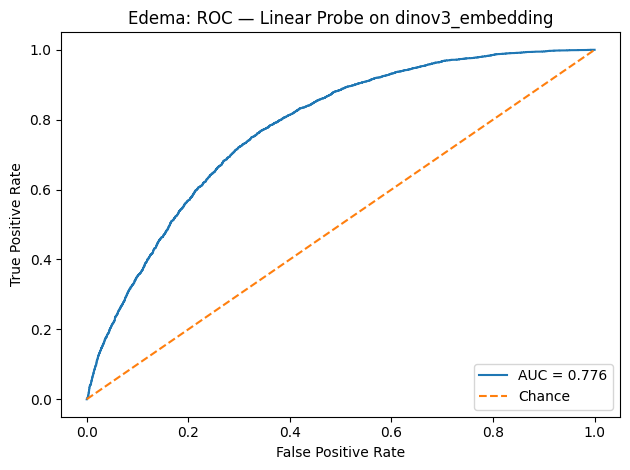

In [13]:
# ----------------------------
# config
PARQUET_PATH = "/home/rmuthy2/Disease_Classification/llembeddings.parquet"  # <-- set this
EMBED_COL = "dinov3_embedding"     # or "dinov3_embedding"
TARGET_COL = "Edema"          # note the space
TEST_SIZE = 0.2
RANDOM_STATE = 42
# ----------------------------

def parse_embedding(x):
    """
    Handles list/np.array or stringified list (e.g., '[0.1, 0.2, ...]').
    Returns a 1D numpy array.
    """
    if isinstance(x, (list, np.ndarray)):
        return np.asarray(x, dtype=float)
    if isinstance(x, str):
        try:
            return np.asarray(ast.literal_eval(x), dtype=float)
        except Exception:
            # Try comma-separated fallback
            parts = [p for p in x.strip("[]() ").split(",") if p]
            return np.asarray([float(p) for p in parts], dtype=float)
    raise ValueError(f"Unsupported embedding type: {type(x)}")

def load_balanced_embeddings(parquet_path, embed_col, target_col):
    df = pd.read_parquet(parquet_path)

    # Keep rows that have target and embedding
    df = df[[embed_col, target_col]].dropna()

    # Parse embeddings to arrays
    embs = df[embed_col].apply(parse_embedding)

    # Sanity: ensure fixed dim
    dim = len(embs.iloc[0])
    if not embs.apply(lambda a: len(a) == dim).all():
        raise ValueError("Embeddings have inconsistent dimensions.")

    X_all = np.vstack(embs.values)
    y_all = df[target_col].astype(int).values

    # Balance classes by undersampling the majority BEFORE split
    idx0 = np.where(y_all == 0)[0]
    idx1 = np.where(y_all == 1)[0]
    n = min(len(idx0), len(idx1))
    rng = np.random.default_rng(RANDOM_STATE)
    idx0_s = rng.choice(idx0, size=n, replace=False)
    idx1_s = rng.choice(idx1, size=n, replace=False)
    sel = np.concatenate([idx0_s, idx1_s])
    rng.shuffle(sel)

    return X_all[sel], y_all[sel]

def main():
    print(f"Loading {PARQUET_PATH} … using embeddings: {EMBED_COL}")
    X, y = load_balanced_embeddings(PARQUET_PATH, EMBED_COL, TARGET_COL)

    # Stratified split (keeps 50/50 balance in both train & test)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
    )

    # Scale features for linear probe
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s  = scaler.transform(X_test)

    # Simple, strong baseline: L2-logreg
    clf = LogisticRegression(
        penalty="l2",
        solver="liblinear",  # robust for small/medium feature dims
        random_state=RANDOM_STATE,
        max_iter=2000,
        n_jobs=None
    )
    clf.fit(X_train_s, y_train)

    # Evaluate
    prob_test = clf.predict_proba(X_test_s)[:, 1]
    auc = roc_auc_score(y_test, prob_test)
    print(f"\nAUC (test): {auc:.4f}")

    # Threshold at 0.5 for report (you can tune this)
    y_pred = (prob_test >= 0.5).astype(int)
    print("\nClassification Report (test):")
    print(classification_report(y_test, y_pred, digits=4))

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, prob_test)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--", label="Chance")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"Edema: ROC — Linear Probe on {EMBED_COL}")
    plt.legend(loc="lower right")
    plt.tight_layout()
    out_png = Path(f"roc_{EMBED_COL}.png")
    plt.savefig(out_png, dpi=200)
    print(f"\nSaved ROC curve to: {out_png.resolve()}")

if __name__ == "__main__":
    main()




Loading /home/rmuthy2/Disease_Classification/llembeddings.parquet … using embeddings: raddino_embedding

AUC (test): 0.8243

Classification Report (test):
              precision    recall  f1-score   support

           0     0.7639    0.7261    0.7445      5410
           1     0.7389    0.7756    0.7568      5409

    accuracy                         0.7508     10819
   macro avg     0.7514    0.7508    0.7507     10819
weighted avg     0.7514    0.7508    0.7507     10819


Saved ROC curve to: /mnt/NAS3/homes/rmuthy2/Disease_Classification/roc_raddino_embedding.png


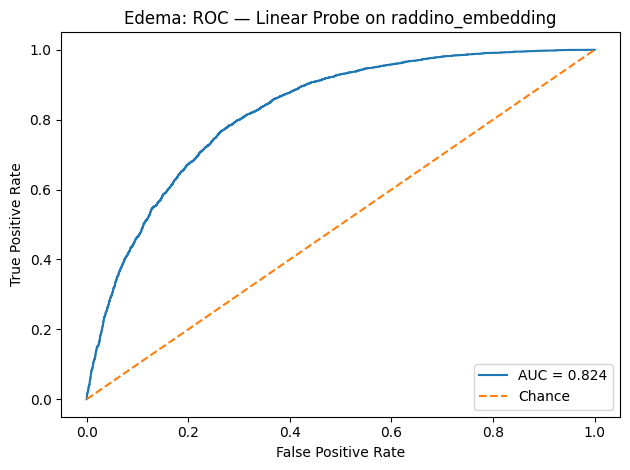

In [14]:

# ----------------------------
# config
PARQUET_PATH = "/home/rmuthy2/Disease_Classification/llembeddings.parquet"  # <-- set this
EMBED_COL = "raddino_embedding"     # or "dinov3_embedding"
TARGET_COL = "Edema"          # note the space
TEST_SIZE = 0.2
RANDOM_STATE = 42
# ----------------------------

def parse_embedding(x):
    """
    Handles list/np.array or stringified list (e.g., '[0.1, 0.2, ...]').
    Returns a 1D numpy array.
    """
    if isinstance(x, (list, np.ndarray)):
        return np.asarray(x, dtype=float)
    if isinstance(x, str):
        try:
            return np.asarray(ast.literal_eval(x), dtype=float)
        except Exception:
            # Try comma-separated fallback
            parts = [p for p in x.strip("[]() ").split(",") if p]
            return np.asarray([float(p) for p in parts], dtype=float)
    raise ValueError(f"Unsupported embedding type: {type(x)}")

def load_balanced_embeddings(parquet_path, embed_col, target_col):
    df = pd.read_parquet(parquet_path)

    # Keep rows that have target and embedding
    df = df[[embed_col, target_col]].dropna()

    # Parse embeddings to arrays
    embs = df[embed_col].apply(parse_embedding)

    # Sanity: ensure fixed dim
    dim = len(embs.iloc[0])
    if not embs.apply(lambda a: len(a) == dim).all():
        raise ValueError("Embeddings have inconsistent dimensions.")

    X_all = np.vstack(embs.values)
    y_all = df[target_col].astype(int).values

    # Balance classes by undersampling the majority BEFORE split
    idx0 = np.where(y_all == 0)[0]
    idx1 = np.where(y_all == 1)[0]
    n = min(len(idx0), len(idx1))
    rng = np.random.default_rng(RANDOM_STATE)
    idx0_s = rng.choice(idx0, size=n, replace=False)
    idx1_s = rng.choice(idx1, size=n, replace=False)
    sel = np.concatenate([idx0_s, idx1_s])
    rng.shuffle(sel)

    return X_all[sel], y_all[sel]

def main():
    print(f"Loading {PARQUET_PATH} … using embeddings: {EMBED_COL}")
    X, y = load_balanced_embeddings(PARQUET_PATH, EMBED_COL, TARGET_COL)

    # Stratified split (keeps 50/50 balance in both train & test)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
    )

    # Scale features for linear probe
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s  = scaler.transform(X_test)

    # Simple, strong baseline: L2-logreg
    clf = LogisticRegression(
        penalty="l2",
        solver="liblinear",  # robust for small/medium feature dims
        random_state=RANDOM_STATE,
        max_iter=2000,
        n_jobs=None
    )
    clf.fit(X_train_s, y_train)

    # Evaluate
    prob_test = clf.predict_proba(X_test_s)[:, 1]
    auc = roc_auc_score(y_test, prob_test)
    print(f"\nAUC (test): {auc:.4f}")

    # Threshold at 0.5 for report (you can tune this)
    y_pred = (prob_test >= 0.5).astype(int)
    print("\nClassification Report (test):")
    print(classification_report(y_test, y_pred, digits=4))

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, prob_test)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--", label="Chance")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"Edema: ROC — Linear Probe on {EMBED_COL}")
    plt.legend(loc="lower right")
    plt.tight_layout()
    out_png = Path(f"roc_{EMBED_COL}.png")
    plt.savefig(out_png, dpi=200)
    print(f"\nSaved ROC curve to: {out_png.resolve()}")

if __name__ == "__main__":
    main()
